# Fake news classification using LSTM, word embeddings, keras sequential

In this one will try to use the text column instead of just the title column; Achieved 92% accuracy

In [1]:
# Courtesy Krish Naik
# Will run the model on kaggle GPU since will be running a keras LSTM RNN sequential model
%config Completer.use_jedi = False

In [2]:
# Read the csv file
import pandas as pd
df = pd.read_csv('../input/fake-news-20800-records/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
# The id column is redundant, we can drop it off
df.drop('id', axis=1, inplace=True)
df.head(1)

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1


In [5]:
df.shape

(20800, 4)

In [4]:
# Check for nan values
df.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
# Since we'll use the text column, 39 of the values are nan, we can drop these rows after
# dropping the title and author columns
df.drop(['title', 'author'], axis=1, inplace=True)
df.dropna(inplace=True)
# dropna had removed certain indices, so we remap them
df.reset_index(inplace=True)
df.head(2)

,index,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,Ever get the feeling your life circles the rou...,0


In [7]:
len(df.text[0])

4930

In [8]:
df.shape

(20761, 3)

In [10]:
df.drop('index', axis=1, inplace=True)
df.head(2)

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0


In [11]:
# Separate the independent and dependent features
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [12]:
X.shape, y.shape

((20761, 1), (20761,))

In [13]:
import tensorflow as tf

In [14]:
tf.__version__

'2.6.4'

In [15]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [16]:
# Vocabulary size
voc_size = 10000

In [17]:
# Make a copy of the independent features dataset
messages = X.copy()

In [18]:
# Text cleaning and preprocessing
import nltk
from nltk.corpus import stopwords
import re

In [20]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
max_length=0
for i in range(len(messages)):
    if (i+1)%1000==0:
        print(i+1)
    review = re.sub(r'[^a-zA-Z]', ' ', messages['text'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    max_length = max(max_length, len(review))
    review = ' '.join(review)
    corpus.append(review)
corpus[0]

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


'hous dem aid even see comey letter jason chaffetz tweet darrel lucu octob subscrib jason chaffetz stump american fork utah imag courtesi michael jolley avail creativ common licens apolog keith olbermann doubt worst person world week fbi director jame comey accord hous democrat aid look like also know second worst person well turn comey sent infam letter announc fbi look email may relat hillari clinton email server rank democrat relev committe hear comey found via tweet one republican committe chairmen know comey notifi republican chairmen democrat rank member hous intellig judiciari oversight committe agenc review email recent discov order see contain classifi inform long letter went oversight committe chairman jason chaffetz set polit world ablaz tweet fbi dir inform fbi learn exist email appear pertin investig case reopen jason chaffetz jasoninthehous octob cours know case comey actual say review email light unrel case know anthoni weiner sext teenag appar littl thing fact matter ch

In [21]:
len(corpus[0])

2849

In [22]:
max_length

12059

In [23]:
# One hot representation
onehot_repr = [one_hot(sentence, voc_size) for sentence in corpus]
onehot_repr[0][:20]

[1197,
 6030,
 4480,
 7512,
 5791,
 6210,
 8915,
 7811,
 4809,
 4556,
 8711,
 8587,
 8144,
 3675,
 7811,
 4809,
 7944,
 5677,
 6388,
 9998]

In [24]:
# Word Embedding Represntation
# Zero padding the sentence vectors
sent_length=max_length
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs[0][:20])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
len(embedded_docs)

20761

In [26]:
# Initialize the feature/embedding dimensions
dim=100

In [27]:
# Instantiate the keras sequential model and add embedding layer, also added dropout layers
model=Sequential()
model.add(Embedding(voc_size,dim,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())

2022-07-10 04:32:33.807301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 04:32:33.921525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 04:32:33.922295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 04:32:33.923984: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 12059, 100)        1000000   
_________________________________________________________________
dropout (Dropout)            (None, 12059, 100)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
len(embedded_docs), y.shape

(20761, (20761,))

In [29]:
# Convert the datasets into numpy arrays
import numpy as np
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [30]:
X_final.shape, y_final.shape

((20761, 12059), (20761,))

In [31]:
# Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [32]:
# Model training
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

2022-07-10 04:33:12.420979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-07-10 04:33:15.275838: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


208/208 [==============================] - 133s 620ms/step - loss: 0.3087 - accuracy: 0.8766 - val_loss: 0.2078 - val_accuracy: 0.9205
Epoch 2/10
208/208 [==============================] - 127s 611ms/step - loss: 0.1449 - accuracy: 0.9487 - val_loss: 0.2158 - val_accuracy: 0.9160
Epoch 3/10
208/208 [==============================] - 127s 609ms/step - loss: 0.0907 - accuracy: 0.9694 - val_loss: 0.2238 - val_accuracy: 0.9175
Epoch 4/10
208/208 [==============================] - 127s 612ms/step - loss: 0.0674 - accuracy: 0.9769 - val_loss: 0.2741 - val_accuracy: 0.8859
Epoch 5/10
208/208 [==============================] - 127s 611ms/step - loss: 0.0460 - accuracy: 0.9844 - val_loss: 0.2753 - val_accuracy: 0.9247
Epoch 6/10
208/208 [==============================] - 128s 614ms/step - loss: 0.0868 - accuracy: 0.9675 - val_loss: 0.2551 - val_accuracy: 0.9157
Epoch 7/10
208/208 [==============================] - 129s 622ms/step - loss: 0.0280 - accuracy: 0.9923 - val_loss: 0.3121 - val_accura

In [33]:
preds = model.predict(X_test)

In [34]:
preds_t = (preds>0.5).astype(int)

In [35]:
preds_t[0], y_test[0]

(array([1]), 1)

In [36]:
preds_t[0:10]

array([[1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0]])

In [37]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
print(classification_report(preds_t, y_test))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1949
           1       0.95      0.89      0.92      2204

    accuracy                           0.92      4153
   macro avg       0.92      0.92      0.92      4153
weighted avg       0.92      0.92      0.92      4153



In [38]:
accuracy_score(preds_t, y_test)

0.91813147122562

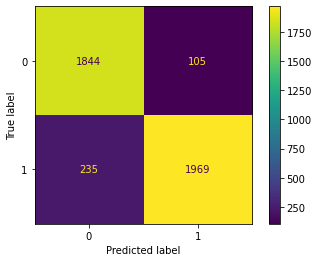

In [39]:
ConfusionMatrixDisplay.from_predictions(preds_t, y_test)

## Achieved 92% accuracy in fake news classification using LSTM RNN with dropout layer and word embedding on text column of dataset instead of title column